### 代码实现

In [1]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

### Dense Layer

In [2]:
# 定义dense block中的dense layer
class _DenseLayer(nn.Module):
    # 构造函数，接收输入通道数num_input_features，输出通道数growth_rate，卷积层的缩放比例bn_size
    def __init__(self, num_input_features, growth_rate, bn_size):
        super().__init__()
        # 定义第一个卷积层，包括BN层、ReLU激活函数和1x1卷积层
        self.conv1 = nn.Sequential(
            nn.BatchNorm2d(num_input_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        )
        # 定义第二个卷积层，包括BN层、ReLU激活函数和3x3卷积层
        self.conv2 = nn.Sequential(
            nn.BatchNorm2d(bn_size * growth_rate),
            nn.ReLU(inplace=True),
            nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        )

    # 定义前向传播函数
    def forward(self, x):
        # BN+ReLU+1x1卷积
        out = self.conv1(x)
        # BN+ReLU+3x3卷积
        out = self.conv2(out)
        # 将输入和输出进行拼接后返回结果
        return torch.cat([x, out], 1)

### Dense Block

In [3]:
# 定义dense block
class _DenseBlock(nn.Module):
    # 构造函数，包含密集连接层的数量num_layers，输入通道数num_input_features，输出通道数growth_rate，卷积层的缩放比例bn_size
    def __init__(self, num_layers, num_input_features, growth_rate, bn_size):
        super().__init__()
        
        # 保存密集连接层的列表
        layers = []
        # 构建num_layers个密集连接层
        for i in range(num_layers):
            # 构建一个密集连接层，其中输入通道数为num_input_features + i * growth_rate逐层递增
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size)
            # 将构建好的密集连接层添加到列表中保存
            layers.append(layer)
        # 将所有密集连接层封装到Sequential中保存为block
        self.block = nn.Sequential(*layers)
        
    # 定义前向传播函数
    def forward(self, x):
        # 经过当前block输出即可
        return self.block(x)

### Transition Layer

In [4]:
# 定义dense block之间的transition layer
class _Transition(nn.Module):
    # 构造函数，输入通道数num_input_features，输出通道数num_output_features
    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        # 定义一个转换层，用于降维和调整特征图的size，包含BN+ReLU+1x1卷积+平均池化层
        self.trans = nn.Sequential(
            nn.BatchNorm2d(num_input_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
    
    # 定义前向传播函数
    def forward(self, x):
        # 经过转换层后输出即可
        return self.trans(x)

### 结构定义

In [5]:
# 定义DenseNet的网络结构
class DenseNet(nn.Module):
    # 构造函数，包含dense block的数量block_config，输入通道数num_input_features，输出通道数growth_rate，
    #           卷积层的缩放比例bn_size和类别数num_classes
    def __init__(self, block_config, num_init_features=64, growth_rate=32, bn_size=4, num_classes=1000):

        super().__init__()

        # 第一部分，7x7卷积+BN+ReLU+最大池化层
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # 下面依次定义dense block和transition layer，对应第二部分和第三部分
        num_features = num_init_features # 记录通道数
        layers = [] # 网络结构保存列表
        # 遍历每层dense block的数量列表
        for i, num_layers in enumerate(block_config):
            # 创建dense block，其中包含num_layers个dense layer
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features, 
                                growth_rate=growth_rate, bn_size=bn_size)
            layers.append(block)
            num_features = num_features + num_layers * growth_rate # 更新特征图维度
            # 如果不是最后一个dense block，则添加一个transition layer，特征图维度除以2
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                layers.append(trans)
                num_features = num_features // 2
        # 添加一个BN层
        layers.append(nn.BatchNorm2d(num_features))
        # 调用nn.Sequential完成第二部分和第三部分
        self.denseblock = nn.Sequential(*layers)

        # 第四部分，全连接层
        self.classifier = nn.Linear(num_features, num_classes)

    # 定义前向传播函数
    def forward(self, x):
        # 第一部分
        features = self.features(x)
        # 第二、三部分
        features = self.denseblock(features)
        # ReLU
        out = F.relu(features, inplace=True)
        # 第四部分，平均池化+全连接层
        out = F.avg_pool2d(out, kernel_size=7, stride=1).view(features.size(0), -1)
        out = self.classifier(out)
        # 输出
        return out

### 封装函数

In [6]:
# 封装函数对应4个模型，num_classes表示类别数
# 其中数值与论文中的数值一致
def densenet121(num_classes=1000):
    return DenseNet(block_config=(6, 12, 24, 16), num_init_features=64, 
                    growth_rate=32, num_classes=num_classes)

def densenet161(num_classes=1000):
    return DenseNet(block_config=(6, 12, 36, 24), num_init_features=96, 
                    growth_rate=48, num_classes=num_classes)

def densenet169(num_classes=1000):
    return DenseNet(block_config=(6, 12, 32, 32), num_init_features=64, 
                    growth_rate=32, num_classes=num_classes)

def densenet201(num_classes=1000):
    return DenseNet(block_config=(6, 12, 48, 32), num_init_features=64, 
                    growth_rate=32, num_classes=num_classes)

### 网络结构

In [7]:
# 查看模型结构及参数量，input_size表示示例输入数据的维度信息
summary(densenet121(), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
DenseNet                                           [1, 1000]                 --
├─Sequential: 1-1                                  [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                                 [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                            [1, 64, 112, 112]         128
│    └─ReLU: 2-3                                   [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                              [1, 64, 56, 56]           --
├─Sequential: 1-2                                  [1, 1024, 7, 7]           --
│    └─_DenseBlock: 2-5                            [1, 256, 56, 56]          --
│    │    └─Sequential: 3-1                        [1, 256, 56, 56]          335,040
│    └─_Transition: 2-6                            [1, 128, 28, 28]          --
│    │    └─Sequential: 3-2                        [1, 128, 28, 28]          33,280
│    └─_DenseBlock: 2-

### torchvision

In [8]:
# 查看torchvision自带的模型结构及参数量
from torchvision import models
summary(models.densenet121(), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [1, 1000]                 --
├─Sequential: 1-1                        [1, 1024, 7, 7]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
│    └─_DenseBlock: 2-5                  [1, 256, 56, 56]          --
│    │    └─_DenseLayer: 3-1             [1, 32, 56, 56]           45,440
│    │    └─_DenseLayer: 3-2             [1, 32, 56, 56]           49,600
│    │    └─_DenseLayer: 3-3             [1, 32, 56, 56]           53,760
│    │    └─_DenseLayer: 3-4             [1, 32, 56, 56]           57,920
│    │    └─_DenseLayer: 3-5             [1, 32, 56, 56]           62,080
│    │    └─_DenseLayer: 3-6             [1, 32, 56, 56]     

### 模型训练

Epoch: 0 Loss: 2.6246336445827274 Acc: 0.03529411764705882
Epoch: 10 Loss: 2.4508019464199036 Acc: 0.17352941176470588
Epoch: 20 Loss: 2.3702510442054217 Acc: 0.257843137254902
Epoch: 30 Loss: 2.310527433003603 Acc: 0.3392156862745098
Epoch: 40 Loss: 2.259450921415037 Acc: 0.37745098039215685
Epoch: 50 Loss: 2.2196614920857183 Acc: 0.41862745098039217
Epoch: 60 Loss: 2.170892211891438 Acc: 0.45784313725490194
Epoch: 70 Loss: 2.1314921703382517 Acc: 0.492156862745098
Epoch: 80 Loss: 2.0921777536321633 Acc: 0.5147058823529411
Epoch: 90 Loss: 2.0567074716229428 Acc: 0.5196078431372549
Epoch: 100 Loss: 2.0274026593455523 Acc: 0.5235294117647059
Epoch: 110 Loss: 1.9874356147854575 Acc: 0.5166666666666667
Epoch: 120 Loss: 1.9602205390341274 Acc: 0.5509803921568628
Epoch: 130 Loss: 1.9483637491000336 Acc: 0.5754901960784313
Epoch: 140 Loss: 1.9112998645671402 Acc: 0.5980392156862745
Epoch: 150 Loss: 1.8827491679198882 Acc: 0.5705882352941176
Epoch: 160 Loss: 1.8423764428096985 Acc: 0.61862745

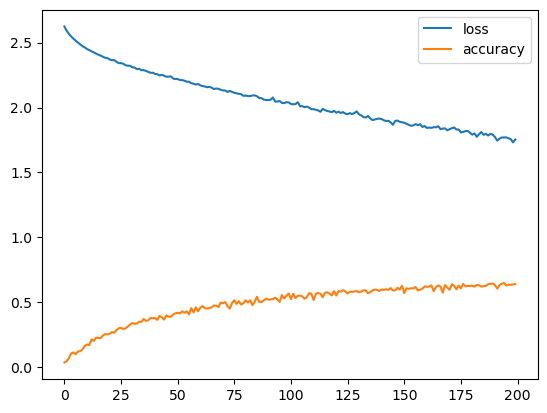

Accuracy: 0.6392156862745098


In [9]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import *
import numpy as np
import sys

# 设备检测，若未检测到cuda设备则在CPU上运行
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置随机种子
torch.manual_seed(0)

# 定义模型、优化器、损失函数
model = densenet121(num_classes=102).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# 设置训练集的数据变换，进行数据增强
trainform_train = transforms.Compose([
    transforms.RandomRotation(30), # 随机旋转 -30度到30度之间
    transforms.RandomResizedCrop((224, 224)), # 随机比例裁剪并进行resize
    transforms.RandomHorizontalFlip(p = 0.5), # 随机水平翻转
    transforms.RandomVerticalFlip(p = 0.5), # 随机垂直翻转
    transforms.ToTensor(),  # 将数据转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 设置测试集的数据变换，不进行数据增强，仅使用resize和归一化
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # resize
    transforms.ToTensor(),  # 将数据转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载训练数据，需要特别注意的是Flowers102数据集，test簇的数据量较多些，所以这里使用"test"作为训练集
train_dataset = datasets.Flowers102(root='../data/flowers102', split="test", download=True, transform=trainform_train)
# 实例化训练数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
# 加载测试数据，使用"train"作为测试集
test_dataset = datasets.Flowers102(root='../data/flowers102', split="train", download=True, transform=transform_test)
# 实例化测试数据加载器
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# 设置epoch数并开始训练
num_epochs = 200  # 设置epoch数
loss_history = []  # 创建损失历史记录列表
acc_history = []   # 创建准确率历史记录列表

# tqdm用于显示进度条并评估任务时间开销
for epoch in tqdm(range(num_epochs), file=sys.stdout):
    # 记录损失和预测正确数
    total_loss = 0
    total_correct = 0
    
    # 批量训练
    model.train()
    for inputs, labels in train_loader:
        # 将数据转移到指定计算资源设备上
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 预测、损失函数、反向传播
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 记录训练集loss
        total_loss += loss.item()
    
    # 测试模型，不计算梯度
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            # 将数据转移到指定计算资源设备上
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 预测
            outputs = model(inputs)
            # 记录测试集预测正确数
            total_correct += (outputs.argmax(1) == labels).sum().item()
        
    # 记录训练集损失和测试集准确率
    loss_history.append(np.log10(total_loss))  # 将损失加入损失历史记录列表，由于数值有时较大，这里取对数
    acc_history.append(total_correct / len(test_dataset))# 将准确率加入准确率历史记录列表
    
    # 打印中间值
    if epoch % 10 == 0:
        tqdm.write("Epoch: {0} Loss: {1} Acc: {2}".format(epoch, loss_history[-1], acc_history[-1]))

# 使用Matplotlib绘制损失和准确率的曲线图
import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='accuracy')
plt.legend()
plt.show()

# 输出准确率
print("Accuracy:", acc_history[-1])